# Exposure Time Predictor
Use observing conditions (sampled at earliest a few min ago, and many older points) to predict exposure time for next exposure at a new position, airmass, etc

### Features vs. Answers
 * Features: obsdb statistics since that's what see when observing
 * Answers: expfactor using depth in CP images as that's what actually wan to achieve, which is NOT expfactor column in the obsdb db! 

### Prediction
expfactor (exptime divided by a given band's nominal)

### Features

### Notes
 * supervised
 * online or batch?
 * regression classifier, model based
 * performance: RMSE
 * scaling of features: expfactor 
 * cleaning
  - transp > 0.9 for 50 consecutive exposures

# Starting where "addylabel_and_splittraintest" left off

In [139]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import pandas as pd
import seaborn as sns
sns.set_context("notebook")

# to make this notebook's output stable across runs
np.random.seed(7)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

%load_ext autoreload
%autoreload 2

REPO_DIR= os.path.join(os.environ['HOME'],
                       'PhdStudent/Research/desi/ml_data/')
DB_DIR= os.path.join(REPO_DIR,'obsbot/obsdb')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [208]:
from exptime_predictor.data import GetData,Clean,AddYlabel,Split_TrainTest
d= GetData(REPO_DIR)
d.fetch()
df = d.load()

df= Clean().keep_science_exposures(df)
df= Clean().add_night_obs(df)
df= Clean().order_by_mjd(df)
df= Clean().add_hr_obs(df)

#df= Clean().drop_bad_transp(df, thresh=0.9)
df= Clean().drop_nights_wfew_exposures(df, nexp=20)

df= AddYlabel().add_tneed(df)
df= AddYlabel().constrain_tneed(df)

df_train,df_test= Split_TrainTest().random_sampling(df)
# Prevent accidental ref to full data set
del df

UNIX cmd: git pull origin master
UNIX cmd: git checkout 84d63bb9aa33b
Reading sqlite db: /Users/kaylan1/PhdStudent/Research/desi/ml_data/obsbot/obsdb/decam.sqlite3
Has tables:  [('django_migrations',), ('sqlite_sequence',), ('obsdb_measuredccd',)]
executing query: select * from obsdb_measuredccd
isGRZ 24116/28833
isObject 21758/28833
isScience 20991/28833
longExp 21750/28833
allCuts 20955/28833
Cutting to < 20 exposures: 20724/20955
Cutting to 19388/20724


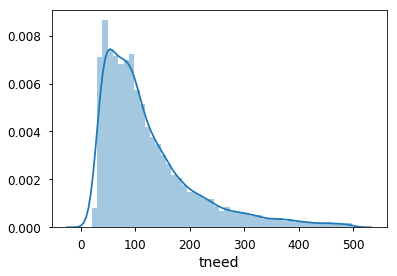

In [209]:
sns.distplot(df_train['tneed'])

In [191]:
corr_matrix = df_train.corr()
corr_matrix["tneed"].sort_values(ascending=False)

tneed           1.000000
expfactor       0.901802
exptime         0.624153
seeing          0.546336
airmass         0.366852
passnumber      0.340462
tileid          0.306882
ebv             0.237177
decbore         0.230081
deccenter       0.230062
tileebv         0.214355
id              0.148426
affine_dxx      0.119427
affine_dyy      0.119315
affine_y0       0.119248
affine_x0       0.119248
rabore          0.107951
racenter        0.105592
nmatched        0.081766
affine_dxy      0.038710
dy              0.007984
affine_dy      -0.023349
affine_dyx     -0.025496
mjd_obs        -0.028283
affine_dx      -0.031628
expnum         -0.039131
hr_obs         -0.076326
dx             -0.077593
night_obs      -0.098889
sky            -0.218220
transparency   -0.257332
zeropoint      -0.565250
bad_pixcnt           NaN
readtime             NaN
Name: tneed, dtype: float64

# Inspect nights with 50-200 exposures

In [170]:
a=df_train['night_obs'].value_counts().rename("cnt").to_frame()
nights= a.index[ (a['cnt'] > 50) & (a['cnt'] < 200)]
nights= nights.values
np.sort(nights)

array([20141227, 20141228, 20141230, 20150109, 20150414, 20151010,
       20160108, 20160116, 20161114, 20161227, 20161228, 20170331,
       20170405, 20170418, 20170504, 20170512, 20170514, 20170521,
       20170731, 20170818])

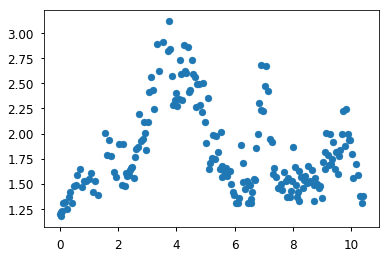

In [171]:
isNight= df_train['night_obs'] == nights[0]
plt.scatter(df_train.loc[isNight,'hr_obs'],
            df_train.loc[isNight,'seeing'])

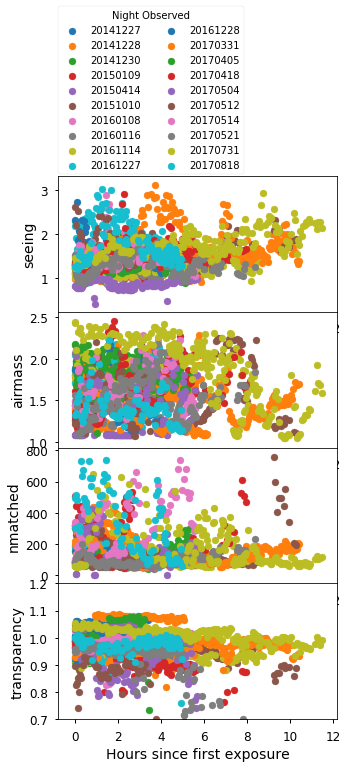

In [172]:
stats= ['seeing','airmass','nmatched','transparency']
lims= dict(seeing= None,
           transparency=[0.7,1.2],
           airmass=None,
           nmatched=None)

fig,ax= plt.subplots(len(stats),1,figsize=(5,10))
plt.subplots_adjust(hspace=0)

for night in np.sort(nights):
    #if '2014' in str(night):
    isNight= df_train['night_obs'] == night
    for iax,stat in enumerate(stats):
        y= X[oneNight, ix[stat]]
        ax[iax].scatter(df_train.loc[isNight,'hr_obs'],
                        df_train.loc[isNight,stat],
                        label= night)
    leg= ax[0].legend(loc=(0,1.01),ncol=2,title='Night Observed')
    xlab= ax[-1].set_xlabel('Hours since first exposure')
    for iax,stat in enumerate(stats):
        ylab= ax[iax].set_ylabel(stat)
        if lims[stat]:
            ax[iax].set_ylim(lims[stat])

# Repackage for ML

In [174]:
df_train['obstype'].value_counts()

object    8498
Name: obstype, dtype: int64

In [163]:
df_train['object'].value_counts().head(20)

DeCaLS            24
test              19
junk              15
pointing          14
HexapodUpdate      8
                   7
DECaLS_17034_r     4
Hexapod Update     4
hexapod update     3
DECaLS_39489_z     3
DECaLS_23567_z     3
DECaLS_23656_z     3
DECaLS_38471_z     3
DECaLS_17050_z     3
DECaLS_32893_z     3
DECaLS_31081_z     2
DECaLS_38427_z     2
DECaLS_47602_g     2
DECaLS_18249_r     2
DECaLS_29760_z     2
Name: object, dtype: int64

In [165]:
df_train[df_train['object'].str.lower().str.contains('decals') == False]['exptime'].value_counts()

10.0    26
30.0    24
5.0     18
80.0     7
3.0      4
20.0     4
57.0     3
90.0     2
77.0     2
81.0     2
55.0     2
56.0     1
76.0     1
Name: exptime, dtype: int64

In [200]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(df_train['band'])
print(encoder.classes_)
housing_cat_1hot

['g' 'r' 'z']


array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ..., 
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

In [234]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

# Pipeline: DataFrame to Numpy array
class df2array(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.cols].values
    
class df2binary(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        encoder = LabelBinarizer()
        list_of_mat= [encoder.fit_transform(X[col].values)
                      for col in self.cols]
        return np.concatenate(list_of_mat,axis=1)

categ_cols = ['band','passnumber']
not_num_cols= ['bad_pixcnt','readtime','expnum',
               'id','tileid','expfactor',
               'object','obstype','extension',
               'filename','camera','md5sum','tneed'] + categ_cols

num_cols = list(df_train.columns)
for col in not_num_cols:
    num_cols.remove(col)
print('numerical cols= ',num_cols)
print('categorical cols= ',categ_cols)

num_pipeline = Pipeline([
        ('df2array', df2array(num_cols)),
        #('imputer', Imputer(strategy="median")),
        ('stdize', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        #('df2array', df2array(categ_cols)),
        ('df2binary', df2binary(categ_cols)),
    ])

numerical cols=  ['exptime', 'mjd_obs', 'airmass', 'racenter', 'deccenter', 'rabore', 'decbore', 'ebv', 'zeropoint', 'transparency', 'seeing', 'sky', 'dx', 'dy', 'nmatched', 'tileebv', 'affine_dx', 'affine_dxx', 'affine_dxy', 'affine_dy', 'affine_dyx', 'affine_dyy', 'affine_x0', 'affine_y0', 'night_obs', 'hr_obs']
categorical cols=  ['band', 'passnumber']


In [236]:
from sklearn.pipeline import FeatureUnion

the_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

x_train = the_pipeline.fit_transform(df_train)
print(x_train.shape)
x_train


(8498, 33)


array([[ 0.15168253, -2.00561374,  1.0166822 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.21099499, -2.00560372,  1.58949698, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.19122417, -2.00559865,  1.48841202, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [-0.81708766,  1.28444313, -1.27457692, ...,  0.        ,
         1.        ,  0.        ],
       [-0.38212961,  1.28444849, -0.43220224, ...,  1.        ,
         0.        ,  0.        ],
       [-0.87640012,  1.2844544 , -1.24088193, ...,  0.        ,
         1.        ,  0.        ]])

# Select and train a model 

In [114]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [115]:
# let's try the full pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]


Compare against the actual values:

In [116]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [117]:
some_data_prepared

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

In [118]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.198198489234

In [119]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.895990018973

In [120]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=42,
           splitter='best')

In [121]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

# Fine-tune your model

In [123]:
cross_val_score?

In [122]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [124]:
LinearR

[ -4.93253574e+09  -4.46604419e+09  -5.24814577e+09  -5.00719015e+09
  -5.05884059e+09  -5.71253188e+09  -4.92377176e+09  -4.90775608e+09
  -5.68071094e+09  -5.07262895e+09]


In [126]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [ 70232.0136482   66828.46839892  72444.08721003  70761.50186201
  71125.52697653  75581.29319857  70169.59286164  70055.37863456
  75370.49116773  71222.39081244]
Mean: 71379.0744771
Standard deviation: 2458.31882043


In [127]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 66782.73843989  66960.118071    70347.95244419  74739.57052552
  68031.13388938  71193.84183426  64969.63056405  68281.61137997
  71552.91566558  67665.10082067]
Mean: 69052.4613635
Standard deviation: 2731.6740018


In [128]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [129]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21941.911027380233

In [130]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [ 51650.94405471  48920.80645498  52979.16096752  54412.74042021
  50861.29381163  56488.55699727  51866.90120786  49752.24599537
  55399.50713191  53309.74548294]
Mean: 52564.1902524
Standard deviation: 2301.87380392


In [131]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69052.461363
std       2879.437224
min      64969.630564
25%      67136.363758
50%      68156.372635
75%      70982.369487
max      74739.570526
dtype: float64

In [86]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

In [132]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

The best hyperparameter combination found:

In [133]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [134]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [140]:
cvres.keys()

dict_keys(['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score', 'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_features', 'param_n_estimators', 'param_bootstrap', 'params'])

In [141]:
cvres = grid_search.cv_results_
for mean_score,std_score, params in zip(cvres["mean_test_score"], cvres["std_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score),np.sqrt(std_score), params)

63825.0479302 10773.5494371 {'max_features': 2, 'n_estimators': 3}
55643.8429091 11392.1873564 {'max_features': 2, 'n_estimators': 10}
53380.6566859 12623.9806065 {'max_features': 2, 'n_estimators': 30}
60959.1388585 13000.1105598 {'max_features': 4, 'n_estimators': 3}
52740.5841667 11307.0704473 {'max_features': 4, 'n_estimators': 10}
50374.1421461 10999.7030522 {'max_features': 4, 'n_estimators': 30}
58661.2866462 13726.7206754 {'max_features': 6, 'n_estimators': 3}
52009.9739798 12103.567305 {'max_features': 6, 'n_estimators': 10}
50154.1177737 11329.5185722 {'max_features': 6, 'n_estimators': 30}
57865.3616801 11075.5701016 {'max_features': 8, 'n_estimators': 3}
51730.0755087 11803.6128258 {'max_features': 8, 'n_estimators': 10}
49694.8514333 10437.4105116 {'max_features': 8, 'n_estimators': 30}
62874.4073931 13778.666248 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54561.9398157 12559.5161223 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59416.6463145 8

In [91]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_bootstrap,param_max_features,param_n_estimators,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.055782,0.003593,-4.073637e+09,-1.107354e+09,NaN,2,3,"{'max_features': 2, 'n_estimators': 3}",18,-3.963584e+09,...,-4.194135e+09,-1.116843e+09,-3.906732e+09,-1.112813e+09,-4.169669e+09,-1.129842e+09,0.000631,0.000542,1.160694e+08,1.927217e+07
1,0.172177,0.008357,-3.096237e+09,-5.813707e+08,NaN,2,10,"{'max_features': 2, 'n_estimators': 10}",11,-3.070368e+09,...,-3.124982e+09,-5.780873e+08,-2.865117e+09,-5.713421e+08,-3.169914e+09,-5.797944e+08,0.002452,0.000872,1.297819e+08,6.782553e+06
2,0.549370,0.024622,-2.849495e+09,-4.394633e+08,NaN,2,30,"{'max_features': 2, 'n_estimators': 30}",9,-2.697829e+09,...,-2.943808e+09,-4.374429e+08,-2.619893e+09,-4.374715e+08,-2.968460e+09,-4.451903e+08,0.031675,0.001817,1.593649e+08,2.961109e+06
3,0.108659,0.003603,-3.716017e+09,-9.850011e+08,NaN,4,3,"{'max_features': 4, 'n_estimators': 3}",16,-3.729600e+09,...,-3.736527e+09,-9.172986e+08,-3.404974e+09,-1.035901e+09,-3.914186e+09,-9.711998e+08,0.005413,0.000532,1.690029e+08,4.047487e+07
4,0.345844,0.010100,-2.781569e+09,-5.160154e+08,NaN,4,10,"{'max_features': 4, 'n_estimators': 10}",8,-2.667093e+09,...,-2.891599e+09,-4.960301e+08,-2.613393e+09,-5.422542e+08,-2.949550e+09,-5.158794e+08,0.005767,0.001052,1.278498e+08,1.498960e+07
5,0.890049,0.025157,-2.537554e+09,-3.878685e+08,NaN,4,30,"{'max_features': 4, 'n_estimators': 30}",3,-2.387199e+09,...,-2.663178e+09,-3.789712e+08,-2.397951e+09,-4.036920e+08,-2.649850e+09,-3.846171e+08,0.040411,0.001709,1.209935e+08,8.424973e+06
6,0.134878,0.003163,-3.441147e+09,-9.030212e+08,NaN,6,3,"{'max_features': 6, 'n_estimators': 3}",14,-3.119576e+09,...,-3.587747e+09,-9.360639e+08,-3.331544e+09,-9.025026e+08,-3.577062e+09,-8.612945e+08,0.003447,0.000230,1.884229e+08,2.639683e+07
7,0.441237,0.009476,-2.705037e+09,-5.014210e+08,NaN,6,10,"{'max_features': 6, 'n_estimators': 10}",6,-2.553481e+09,...,-2.762945e+09,-4.996537e+08,-2.519522e+09,-4.989516e+08,-2.906270e+09,-5.063617e+08,0.026262,0.001327,1.464963e+08,3.357661e+06
8,1.293729,0.025095,-2.515436e+09,-3.840197e+08,NaN,6,30,"{'max_features': 6, 'n_estimators': 30}",2,-2.371924e+09,...,-2.607962e+09,-3.805596e+08,-2.351220e+09,-3.856159e+08,-2.662399e+09,-3.904866e+08,0.043359,0.000991,1.283580e+08,3.796810e+06
9,0.154177,0.003283,-3.348400e+09,-8.884890e+08,NaN,8,3,"{'max_features': 8, 'n_estimators': 3}",13,-3.351347e+09,...,-3.396841e+09,-8.596460e+08,-3.131753e+09,-8.893698e+08,-3.509451e+09,-9.146734e+08,0.002721,0.000364,1.226683e+08,2.730057e+07


In [92]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff6886eb978>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff6886eb630>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=0)

In [93]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49147.1524172 {'max_features': 7, 'n_estimators': 180}
51396.8768969 {'max_features': 5, 'n_estimators': 15}
50798.3025423 {'max_features': 3, 'n_estimators': 72}
50840.744514 {'max_features': 5, 'n_estimators': 21}
49276.1753033 {'max_features': 7, 'n_estimators': 122}
50776.7360494 {'max_features': 3, 'n_estimators': 75}
50682.7075546 {'max_features': 3, 'n_estimators': 88}
49612.1525305 {'max_features': 5, 'n_estimators': 100}
50472.6107336 {'max_features': 3, 'n_estimators': 150}
64458.2538503 {'max_features': 5, 'n_estimators': 2}


In [94]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([  7.33442355e-02,   6.29090705e-02,   4.11437985e-02,
         1.46726854e-02,   1.41064835e-02,   1.48742809e-02,
         1.42575993e-02,   3.66158981e-01,   5.64191792e-02,
         1.08792957e-01,   5.33510773e-02,   1.03114883e-02,
         1.64780994e-01,   6.02803867e-05,   1.96041560e-03,
         2.85647464e-03])

In [95]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36615898061813418, 'median_income'),
 (0.16478099356159051, 'INLAND'),
 (0.10879295677551573, 'pop_per_hhold'),
 (0.073344235516012421, 'longitude'),
 (0.062909070482620302, 'latitude'),
 (0.056419179181954007, 'rooms_per_hhold'),
 (0.053351077347675809, 'bedrooms_per_room'),
 (0.041143798478729635, 'housing_median_age'),
 (0.014874280890402767, 'population'),
 (0.014672685420543237, 'total_rooms'),
 (0.014257599323407807, 'households'),
 (0.014106483453584102, 'total_bedrooms'),
 (0.010311488326303787, '<1H OCEAN'),
 (0.0028564746373201579, 'NEAR OCEAN'),
 (0.0019604155994780701, 'NEAR BAY'),
 (6.0280386727365991e-05, 'ISLAND')]

In [96]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [97]:
final_rmse

47766.003966433083

## Model persistence using joblib

In [99]:
my_model = full_pipeline_with_predictor

In [100]:
from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF